## Functions

In [644]:
# Old Strategy

import scipy.stats as st
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive('True')
'exec(%matplotlib inline)'
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from forex_python.converter import get_rate
from datetime import datetime, date 
import time 

# Basic data collection functions
def getPrice(ticker, start='2013-08-07', end='2019-10-17'):
    df = dr.data.get_data_yahoo(ticker, start, end)
    df.info()
    return df['Adj Close']

def logRet(df):
    # Plots daily returns
    pri = df
    daily_returns = pri * 0
    for i in range(1, len(pri)):
        daily_returns[i] = np.log(pri[i]/pri[i-1])
    return daily_returns

# For a portfolio's returns, gives the index
def indx(ret):
    ind = ret * 0
    ind += 100
    for i in range(1, len(ret)):
        ind[i] = ind[i-1] * (1+ret[i])
    return ind

# Cumulative returns

def cumRet(rets):
    cumR = rets * 0 
    for t in range(1, len(cumR)):
        cumR[t] = cumR[t-1] + rets[t]
    return cumR

def plotCumRet(cumR):
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.plot(cumR)
    ax.set_xlabel('Month')
    ax.set_ylabel('% Return')
    ax.set_title('Cumulative Return')
    plt.show()

def plotCumRets(rets):
    c = cumRet(rets)
    plotCumRet(c)

# Risk metric functions

def maxDrawdown(pri, window=252):
    Roll_Max = pri.rolling(window, min_periods=200).max()
    Daily_Drawdown = pri/Roll_Max - 1.0
    Daily_Drawdown *= -1
    Max_Daily_Drawdown = np.max(Daily_Drawdown)
    print("Max daily drawdown: {}%".format(round(Max_Daily_Drawdown, 2)))
    return Max_Daily_Drawdown

def plotDrawdown(pri, window=252):
    Roll_Max = pri.rolling(window, min_periods=200).max()
    Daily_Drawdown = pri/Roll_Max - 1.0
    Daily_Drawdown *= -1
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    ax.plot(Daily_Drawdown)
    ax.set_xlabel('Year')
    ax.set_ylabel('%')
    ax.set_title('Drawdown')
    plt.show()

def valueAR(dailyRet, per): #Historical
    pci = np.percentile(dailyRet, per)
    print("VaR at {0}%: {1}%".format(per, round(-100*pci, 3)))
    return pci

def cVAR(dailyRet, per):
    pci = np.percentile(dailyRet, per)
    sumBad = 0
    t = 0
    for i in range(1, len(dailyRet)):
        if dailyRet[i] <= pci:
            t += 1
            sumBad += dailyRet[i]
    if t > 0:
        condVaR = sumBad / t
    else:
        condVaR = 0
    print("CVaR at {0}%: {1}%".format(per, round(-100*condVaR, 3)))
    return condVaR

def semiv(dayRet, port=False):
    m = np.mean(dayRet)
    low = []
    for i in range(1, len(dayRet)):
        if dayRet[i] <= m:
            low.append(dayRet[i])
    stand = np.std(low)
    if port: 
        stand *= np.sqrt(21)
    print("SemiSD: {}".format(round(stand, 6)))
    return stand

# Use pricing data
def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for i in range(1, len(X)):
        if X[i] > peak:
            peak = X[i]
        dd = (peak - X[i]) / peak
        if dd > mdd:
            mdd = dd
    return mdd

# SD, SemiV, Drawdown, VaR, CVaR, Skewness, Kurtosis
def riskMetrics(ret, name = "portfolio", varP = 5, cvarP = 5, port=False):
    print("Risk metrics for {}".format(name))
    pri = indx(ret)
    print("Average return: {}%".format(round(100*np.mean(ret), 6)))
    sd = np.std(ret)
    if port: 
        print("SD: {}".format(np.round(sd*np.sqrt(21), 6)))
    else: 
        print("SD: {}".format(np.round(sd, 6)))
    semiv(ret, port=port)
    dd = max_drawdown(pri)
    print("Max DD: {}%".format(round(100*dd, 2)))
    valueAR(ret, varP)
    cVAR(ret, cvarP)
    sk = st.skew(ret)
    print("Skewness: {}".format(round(sk, 6)))
    kurt = st.kurtosis(ret)
    print("Kurtosis: {}".format(round(kurt+3, 6)))
    print("Excess Kurtosis: {}".format(round(kurt, 6)))
    print("")
    
def cVARNP(dailyRet, per):
    pci = np.percentile(dailyRet, per)
    sumBad = 0
    t = 0
    for i in range(1, len(dailyRet)):
        if dailyRet[i] <= pci:
            t += 1
            sumBad += dailyRet[i]
    if t > 0:
        condVaR = sumBad / t
    else:
        condVaR = 0
    print("CVaR at {0}%: {1}%".format(per, np.round(float(-100*condVaR), 3)))
    return condVaR

def riskMetricsNP(ret, name = "portfolio", varP = 5, cvarP = 5, port=False):
    print("Risk metrics for {}".format(name))
    pri = indx(ret)
    print("Average return: {}%".format(round(100*np.mean(ret), 6)))
    sd = np.std(ret)
    # Note change for monthly to work for portfolio 
    if port: 
        print("SD: {}".format(np.round(sd*np.sqrt(21), 6)))
    else: 
        print("SD: {}".format(np.round(sd, 6)))
    semiv(ret, port=port)
    dd = max_drawdown(pri)
    print("Max DD: {}%".format(np.round(float(100*dd), 2)))
    valueAR(ret, varP)
    cVARNP(ret, cvarP)
    sk = st.skew(ret)
    print("Skewness: {}".format(np.round(float(sk), 6)))
    kurt = st.kurtosis(ret)
    print("Kurtosis: {}".format(round(kurt+3, 6)))
    print("Excess Kurtosis: {}".format(np.round(float(kurt), 6)))
    print("")
    
def getCSVPrice(t, start='2018-1-1', end='2020-1-1'): 
    prices = dfP.loc[start : end, t].values
    return prices

def getCSVRet(t, start='2018-1-1', end='2020-1-1'): 
    rets = dfRet.loc[start : end, t].values
    return rets 

def strip_replace(x):
    return x.strip("'").strip('[').strip(']').strip().replace("'", "").split(', ')

def sameMonth(d): 
    ld = d.index.max()
    lm = ld.month
    ly = ld.year
    td = date.today()
    tm = td.month
    ty = td.year
    if (lm, ly) != (tm, ty): 
        print('Not the same')
        error
    return 0

# Tickers

In [645]:
#Alternative Energy
sym_AltEn=["NLR","FAN","PBD","TAN"]
#Consumer
sym_Cons=["PBS","PBJ","PEJ","PMR","BJK","XHB","CARZ","IBUY"]
#Energy
sym_Ener=["PXE","FRAK","PXJ"]
#Financials
sym_Fina=["KBWP","IAI","PSP","KBWR","KBWB"]
#Healtcare
sym_Heal=["IHI","IHF","PBE","PJP","CNCR"]
#Industrials & Infrastructure
sym_Indu=["GII","PIO","PPA","IYT","SEA","JETS"]
#Materials, Metals and Mining
sym_Mate=["HAP","GDX","GDXJ","KOL","SLX","XME"]
#Technology
sym_Tech=["PSJ","SKYY","PXQ","PNQI","PSI","SOCL","FONE","ROBO", "ESPO"]
#Utilities
sym_Util= ["GRID"]
# Add ESPO for esports ETF 

#Combining all symbols
sym_all=sym_AltEn+sym_Cons+sym_Ener+sym_Fina+sym_Heal+sym_Indu+sym_Mate+sym_Tech+sym_Util

tickers = sym_all
tickers.append('VTV')
tickers.append('SPY')
weights = np.zeros(len(tickers))
prices = 10 * np.ones(len(tickers))

print(tickers, '\n\n', weights, '\n\n', prices)

['NLR', 'FAN', 'PBD', 'TAN', 'PBS', 'PBJ', 'PEJ', 'PMR', 'BJK', 'XHB', 'CARZ', 'IBUY', 'PXE', 'FRAK', 'PXJ', 'KBWP', 'IAI', 'PSP', 'KBWR', 'KBWB', 'IHI', 'IHF', 'PBE', 'PJP', 'CNCR', 'GII', 'PIO', 'PPA', 'IYT', 'SEA', 'JETS', 'HAP', 'GDX', 'GDXJ', 'KOL', 'SLX', 'XME', 'PSJ', 'SKYY', 'PXQ', 'PNQI', 'PSI', 'SOCL', 'FONE', 'ROBO', 'ESPO', 'GRID', 'VTV', 'SPY'] 

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] 

 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


In [646]:
wmlDateFormat = '%d/%m/%y'
prDateFormat = '%Y-%m-%d'

try: 
    dfList = pd.read_csv(open('WML_Old.csv')).dropna()
    dfList['StartF'] = pd.to_datetime(dfList['StartF'], format=wmlDateFormat).dt.date
    dfList['EndF'] = pd.to_datetime(dfList['EndF'], format=wmlDateFormat).dt.date
    dfList['StartH'] = pd.to_datetime(dfList['StartH'], format=wmlDateFormat).dt.date
    dfList['EndH'] = pd.to_datetime(dfList['EndH'], format=wmlDateFormat).dt.date
    dfList['StartS'] = pd.to_datetime(dfList['StartS'], format=wmlDateFormat).dt.date
    dfList['EndS'] = pd.to_datetime(dfList['EndS'], format=wmlDateFormat).dt.date
    if int(dfList['EndH'].iloc[-1].month) != int(date.today().month)-1 or dfList['StartF'].duplicated().sum() != 0:
        print('Refreshing WML_Old.csv...')
        # Really need to be careful here with the dfList outcome 
        print('Trying existing WML_Old.csv...')
        dfList = pd.read_csv(open('WML_Old.csv')).dropna()
        dfList['StartF'] = pd.to_datetime(dfList['StartF'], format=wmlDateFormat).dt.date
        dfList['EndF'] = pd.to_datetime(dfList['EndF'], format=wmlDateFormat).dt.date
        dfList['StartH'] = pd.to_datetime(dfList['StartH'], format=wmlDateFormat).dt.date
        dfList['EndH'] = pd.to_datetime(dfList['EndH'], format=wmlDateFormat).dt.date
        dfList['StartS'] = pd.to_datetime(dfList['StartS'], format=wmlDateFormat).dt.date
        dfList['EndS'] = pd.to_datetime(dfList['EndS'], format=wmlDateFormat).dt.date

except: 
    print('Error getting WML_Old.csv')
    print('Trying existing WML_Old.csv...')
    dfList = pd.read_csv(open('WML_Old.csv')).dropna()
    dfList['StartF'] = pd.to_datetime(dfList['StartF'], format=wmlDateFormat).dt.date
    dfList['EndF'] = pd.to_datetime(dfList['EndF'], format=wmlDateFormat).dt.date
    dfList['StartH'] = pd.to_datetime(dfList['StartH'], format=wmlDateFormat).dt.date
    dfList['EndH'] = pd.to_datetime(dfList['EndH'], format=wmlDateFormat).dt.date
    dfList['StartS'] = pd.to_datetime(dfList['StartS'], format=wmlDateFormat).dt.date
    dfList['EndS'] = pd.to_datetime(dfList['EndS'], format=wmlDateFormat).dt.date
    print('\n\nold_strategy_get_universe.py missing or failing to update WML_Old.csv\n')

        
if dfList['StartF'].duplicated().sum() != 0: 
    print('\n\nDuplicate value issue in WML_Old.csv\n\n')
    error 

try:
    print('Importing prices...')
    dfP = pd.read_csv(open('PricesSPY.csv'))
    dfP['Date'] = pd.to_datetime(dfP['Date'], format=prDateFormat).dt.date
    dfP = dfP.set_index('Date').sort_index()
    ld = pd.to_datetime(dfP.index.max()).date()
    td = date.today()
    print(td.month, td.year)
    print(ld.month, ld.year)
    if ld.month != td.month: 
        print('Not the same, refreshing data...')
        error 

except:
    print('Error importing prices. Downloading price data...\n')
    dfP = pd.DataFrame()
    dfP[tickers[0]] = getPrice(tickers[0], '1-1-2010', date.today())
    dfP.reset_index(inplace=True)
    for i in range(len(tickers)):
        dfP[tickers[i]] = getPrice(tickers[i], '1-1-2010', date.today()).reset_index()['Adj Close']
    dfP['Date'] = pd.to_datetime(dfP['Date'], format=prDateFormat).dt.date
    dfP = dfP.set_index('Date').sort_index()
    dfP.to_csv('PricesSPY.csv')

try:
    print('Importing returns...')
    dfRet = pd.read_csv(open('ReturnsSPY.csv')).iloc[1:,:]
    dfRet['Date'] = pd.to_datetime(dfRet['Date'], format=prDateFormat)
    dfRet = dfRet.set_index('Date').sort_index()
    ld = pd.to_datetime(dfP.index.max()).date()
    td = date.today()
    print(td.month, td.year)
    print(ld.month, ld.year)
    if ld.month != td.month: 
        print('Not the same, refreshing data')
        error 

except:
    print('Calculating returns...\n')
    dfRet = pd.DataFrame()
    for i in range(len(tickers)):
        dfRet[tickers[i]] = logRet(dfP[tickers[i]])
    dfRet = pd.DataFrame.fillna(dfRet, 0)
    dfRet = dfRet.sort_index()
    dfRet.to_csv('ReturnsSPY.csv')

# Had to be done to avoid nan. Doesn't change returns as they are calculated first 
dfP = dfP.interpolate()

Importing prices...
7 2020
7 2020
Importing returns...
7 2020
7 2020


# Full Run 

In [648]:
# Collect data for each ticker in each list of winners
winners = dfList['Winners']
losers = dfList['Losers']
startF = dfList['StartF']
endF = dfList['EndF']
startH = dfList['StartH']
endH = dfList['EndH']
startS = dfList['StartS']
endS = dfList['EndS']

cumWin = []
cumLoss = []

# Volatility scaling
# Aiming for 12% annual volatility, which is 3.46% monthly
targetSD = np.sqrt(12) / 100 # 0.0346

monthlyReturn = np.zeros(len(winners))
standardDev = np.zeros(len(winners))
numWin = 5
dailyReturns = []
dailyMoRet = []
momWeight = np.zeros(len(winners))
momSD = np.zeros(len(winners))
g_win = np.zeros(len(winners))
g_los = np.zeros(len(winners))
hedgeWeight = np.zeros(len(winners))
g_spy = np.zeros(len(winners))
g_val = np.zeros(len(winners))
moReturns = np.zeros(len(winners))
hedgeReturns = np.zeros(len(winners))

for i in range(len(winners)): 
#for i in range(2): 
    listWin = strip_replace(winners[i])
    listLoss = strip_replace(losers[i])
    numWin = len(listWin)
    
    retWin = 0
    retLoss = 0
    # Tickers 
    for j in range(numWin):
        r = getCSVRet(listWin[j], startH[i], endH[i])
        retWin += r/len(listWin)
        g_win[i] = sum(retWin)
        
        r_l = getCSVRet(listLoss[j], startH[i], endH[i])
        retLoss += r_l/len(listLoss)
        g_los[i] = sum(retLoss)

    # Momentum strategy return
    moRet = retWin - retLoss
    moReturns[i] = sum(moRet)

    # Momentum scaling
    retWinScale = pd.Series(dtype='float64')
    retLossScale = pd.Series(dtype='float64')
    for j in range(numWin): 
        pWin = getCSVPrice(listWin[j], startS[i], endS[i])
        if j == 0: 
            retWinScale = 0 * pd.Series(pWin)
            retLossScale = 0 * pd.Series(pWin)
        retWinScale += getCSVRet(listWin[j], startS[i], endS[i]) 
        pLoss = getCSVPrice(listLoss[j], startS[i], endS[i])
        retLossScale += getCSVRet(listLoss[j], startS[i], endS[i])
    scaleRet = (retWinScale - retLossScale) / len(listWin)
    totalVar = 0
    for j in range(len(scaleRet)):
        retj = float(scaleRet[j])
        totalVar += retj * retj
    monthlyVar = totalVar / 6
    monthlySD = np.sqrt(monthlyVar)
    momSD[i] = monthlySD
    wMo = targetSD / monthlySD

    pSPY = getCSVPrice('SPY', startH[i], endH[i])
    retSPY = getCSVRet('SPY', startH[i], endH[i])
    g_spy[i] = sum(retSPY)
    pVal = getCSVPrice('VTV', startH[i], endH[i])
    retVal = getCSVRet('VTV', startH[i], endH[i])
    g_val[i] = sum(retVal)
    hedgeRet = retVal - retSPY
    hedgeReturns[i] = sum(hedgeRet)

    momWeight[i] = wMo
    # wMo *= .5
    wHedge = 1 - wMo
    hedgeWeight[i] = wHedge
    cash = 1-wHedge-wMo

    fullPort = wMo * moRet + wHedge * hedgeRet
    dailyReturns.extend(fullPort)
    dailyMoRet.extend(moRet)
    # fxRet = get_rate('USD', 'GBP', endH[i]) / get_rate('USD', 'GBP', startH[i]) 
    # fullPort *= fxRet # Gives GBP return 
    monthRet = np.sum(fullPort)
    monthlyReturn[i] = monthRet
    standardDev[i] = np.std(fullPort)
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 

In [649]:
retWinScale, pd.Series(pWin), pd.Series(getCSVRet(listWin[0], startS[0], endS[0]))

(0      0.002259
 1      0.067783
 2     -0.009565
 3      0.004682
 4     -0.044894
          ...   
 119   -0.025526
 120   -0.044800
 121   -0.013661
 122   -0.008757
 123    0.056341
 Length: 124, dtype: float64,
 0      27.797304
 1      28.176178
 2      28.425436
 3      28.305792
 4      28.684666
          ...    
 119    32.700001
 120    33.750000
 121    33.650002
 122    33.049999
 123    33.759998
 Length: 124, dtype: float64,
 0     -0.003532
 1      0.005603
 2      0.026549
 3      0.001409
 4      0.009614
          ...   
 122   -0.005819
 123    0.036596
 124   -0.025178
 125    0.008709
 126   -0.005180
 Length: 127, dtype: float64)

In [650]:
monthlyReturn.mean()*12/(standardDev.mean()*np.sqrt(252))

1.1236131165918735

## Metrics 

Risk metrics for portfolio
Average return: 1.112719%
SD: 0.038691
SemiSD: 0.024422
Max DD: 14.79%
VaR at 5%: 5.377%
CVaR at 5%: 6.851%
Skewness: 0.419963
Kurtosis: 5.01215
Excess Kurtosis: 2.01215



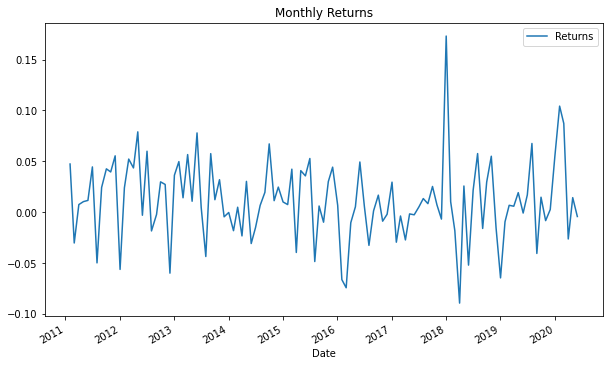

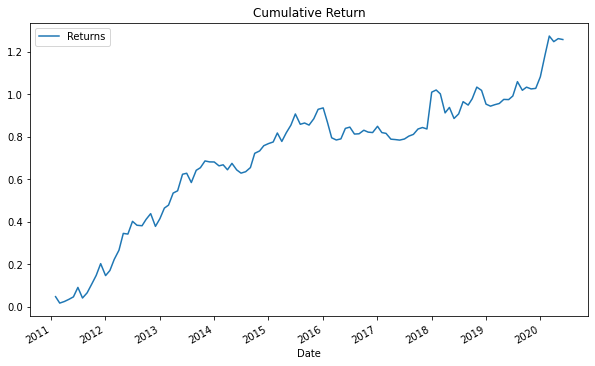

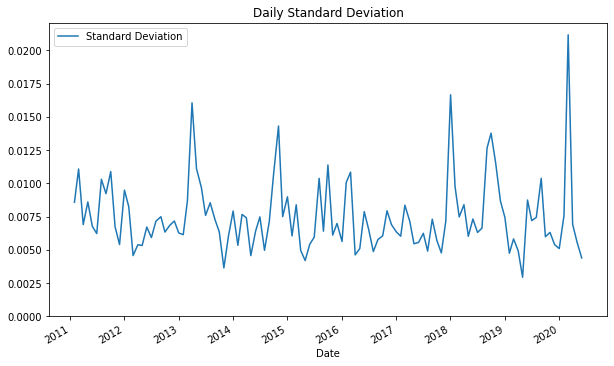

In [651]:
def perform(rets=monthlyReturn, sdev=standardDev): 
    if type(rets) == pd.DataFrame and type(sdev) == pd.DataFrame: 
        dfrets.plot(kind='line', x='Date', y='Returns', title='Monthly Returns', 
                    figsize=(10,6))
        cumu= pd.DataFrame(rets['Returns'].cumsum())
        cumu['Date'] = rets['Date']
        cumu.plot(kind='line', x='Date', y='Returns', title='Cumulative Return', 
                  figsize=(10,6))
        dfstd.plot(kind='line', x='Date', y='Standard Deviation', 
                   title='Daily Standard Deviation', figsize=(10,6), ylim=(0))
    
    else: 
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(100 * rets)
        ax.set_xlabel('Month')
        ax.set_ylabel('Percent')
        ax.set_title('Monthly Returns')
        plt.show()

        riskMetricsNP(rets, 'Whole Portfolio', port=True)
        print('Cash: {}'.format(np.round(cash, 12)))

        fig2, ax2 = plt.subplots()
        ax2.plot(sdev)
        ax2.set_ylim(bottom=0)
        ax2.set_xlabel('Month')
        ax2.set_ylabel('SD')
        ax2.set_title('Portfolio Standard Deviation')
        plt.show()

        plotCumRets(100*np.array(rets))


dfrets = pd.DataFrame(monthlyReturn)
dfrets['Date'] = startH
dfrets['Date'] = pd.to_datetime(dfrets['Date'])
dfrets.columns = ['Returns', 'Date']
dfstd = pd.DataFrame(standardDev)
dfstd['Date'] = startH
dfstd['Date'] = pd.to_datetime(dfstd['Date'])
dfstd.columns = ['Standard Deviation', 'Date']

perform(dfrets, dfstd)
riskMetrics(monthlyReturn)

In [652]:
monthlyReturn

array([ 0.04731096, -0.03032927,  0.00745649,  0.01036382,  0.01153137,
        0.04447582, -0.04989228,  0.02430047,  0.04258099,  0.03951673,
        0.05537542, -0.05630263,  0.02392959,  0.05218398,  0.04347949,
        0.07894658, -0.00305198,  0.05991237, -0.01846496, -0.00231041,
        0.02978556,  0.02722297, -0.05998079,  0.03631143,  0.04968199,
        0.01413288,  0.05660099,  0.01071652,  0.07789133,  0.00464101,
       -0.04362242,  0.05753375,  0.0122241 ,  0.03190878, -0.00457925,
       -0.00032763, -0.01823164,  0.00483559, -0.02337068,  0.03024599,
       -0.03085584, -0.01513874,  0.00661946,  0.01947878,  0.06710235,
        0.01128495,  0.02463034,  0.01001277,  0.00744707,  0.04225649,
       -0.03963556,  0.04081064,  0.03568288,  0.05274202, -0.04856591,
        0.00603245, -0.00987258,  0.03003537,  0.04424586,  0.00667867,
       -0.06634847, -0.07434585, -0.01034921,  0.00527753,  0.04931213,
        0.00602141, -0.0326611 ,  0.00127232,  0.01671367, -0.00

In [653]:
monthlyReturn.cumsum()

array([0.04731096, 0.01698169, 0.02443818, 0.034802  , 0.04633337,
       0.09080919, 0.0409169 , 0.06521737, 0.10779836, 0.14731509,
       0.20269051, 0.14638788, 0.17031747, 0.22250145, 0.26598094,
       0.34492752, 0.34187554, 0.40178792, 0.38332296, 0.38101255,
       0.41079811, 0.43802108, 0.3780403 , 0.41435173, 0.46403372,
       0.4781666 , 0.53476759, 0.54548411, 0.62337544, 0.62801645,
       0.58439403, 0.64192778, 0.65415189, 0.68606067, 0.68148142,
       0.68115379, 0.66292215, 0.66775774, 0.64438706, 0.67463305,
       0.64377721, 0.62863847, 0.63525793, 0.65473671, 0.72183906,
       0.73312401, 0.75775435, 0.76776712, 0.77521419, 0.81747067,
       0.77783512, 0.81864575, 0.85432863, 0.90707066, 0.85850474,
       0.8645372 , 0.85466462, 0.88469999, 0.92894585, 0.93562452,
       0.86927605, 0.7949302 , 0.78458099, 0.78985852, 0.83917066,
       0.84519207, 0.81253097, 0.8138033 , 0.83051696, 0.82163345,
       0.8195506 , 0.84903776, 0.81949605, 0.81570769, 0.78839

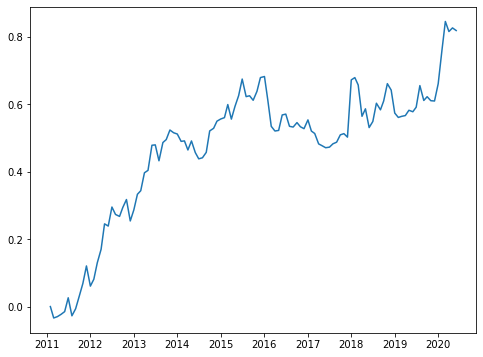

7.285785445934367

In [654]:
plt.figure(figsize=(8,6))
plt.plot(startH, cumRet(monthlyReturn-.0035))
plt.show()
100*((1+cumRet(monthlyReturn-.0035)[-1])**(1/8.5)-1)

## Get Weights

In [655]:
'''
Make one month iteration and return weights vector 
Return price vector also 
'''

def getWeights(i = len(winners)-1): 
    winners = dfList['Winners']
    losers = dfList['Losers']
    startH = dfList['StartH']
    endH = dfList['EndH']

    # Volatility scaling
    # Aiming for 12% annual volatility, which is 3.46% monthly
    targetSD = .0346

    listWin = strip_replace(winners[i])
    listLoss = strip_replace(losers[i])
    numWin = len(listWin)
    p = getCSVPrice(listWin[0], startH[i], endH[i])
    p_l = getCSVPrice(listLoss[0], startH[i], endH[i])
    
    # Tickers
    retWin = 0
    retLoss = 0
    prices = 10 * np.ones(len(tickers))
    for j in range(numWin):
        p = getCSVPrice(listWin[j], startH[i], endH[i])
        r = getCSVRet(listWin[j], startH[i], endH[i])
        retWin += r/len(listWin)
        k = tickers.index(listWin[j])
        prices[k] = p[-1]
        
        p_l = getCSVPrice(listLoss[j], startH[i], endH[i])
        r_l = getCSVRet(listLoss[j], startH[i], endH[i])
        retLoss += r_l/len(listLoss)
        k = tickers.index(listLoss[j])
        prices[k] = p_l[-1]

    # Momentum scaling
    retWinScale = pd.Series(dtype='float64')
    retLossScale = pd.Series(dtype='float64')
    for j in range(numWin): 
        pWin = getCSVPrice(listWin[j], startS[i], endS[i])
        if j == 0: 
            retWinScale = 0 * pd.Series(pWin)
            retLossScale = 0 * pd.Series(pWin)
        retWinScale += getCSVRet(listWin[j], startS[i], endS[i]) 
        pLoss = getCSVPrice(listLoss[j], startS[i], endS[i])
        retLossScale += getCSVRet(listLoss[j], startS[i], endS[i])
    scaleRet = (retWinScale - retLossScale) / len(listWin)
    totalVar = 0
    for j in range(len(scaleRet)):
        retj = float(scaleRet[j])
        totalVar += retj * retj
    monthlyVar = totalVar / 6
    monthlySD = np.sqrt(monthlyVar)
    momSD[i] = monthlySD
    wMo = targetSD / monthlySD

    pSPY = getCSVPrice('SPY', startH[i], endH[i])[-1]
    pVal = getCSVPrice('VTV', startH[i], endH[i])[-1]
    
    # wMo *= .5
    wHedge = 1 - wMo
    cash = 1 - wHedge - wMo
    
    # Weights vector 
    weights = np.zeros(len(tickers))
    for k in range(numWin): 
        j = tickers.index(listWin[k])
        weights[j] = 0.0625 * wMo
    for k in range(numWin): 
        j = tickers.index(listLoss[k])
        weights[j] = -0.0625 * wMo
    
    print(weights)
    # Hedge weights 
    prices[-2] = pVal
    prices[-1] = pSPY
    weights[-2] = wHedge / 2
    weights[-1] = - wHedge / 2
    
    dfWeights = pd.DataFrame(tickers, columns=['Ticker'])
    dfWeights['Weight'] = weights
    dfWeights['Value'] = 10000 * dfWeights['Weight']
    dfWeights['Num. Shares'] = dfWeights['Value'] / prices
    dfWeights['Price'] = prices
    
    return dfWeights

getWeights()[getWeights()['Value'] != 0]

[ 0.          0.          0.          0.01601015  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01601015 -0.01601015 -0.01601015  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01601015  0.          0.01601015  0.01601015  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01601015  0.          0.
  0.        ]
[ 0.          0.          0.          0.01601015  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01601015 -0.01601015 -0.01601015  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01601015  0.          0.01601015  0.01601015  0.          0.
  0.          0.          0.          0.          0.          0.
  0.       

,Ticker,Weight,Value,Num. Shares,Price
3,TAN,0.016010,160.10148,4.434944,36.099998
12,PXE,-0.016010,-160.10148,-16.888343,9.480000
13,FRAK,-0.016010,-160.10148,-2.414145,66.318100
14,PXJ,-0.016010,-160.10148,-67.269526,2.380000
30,JETS,-0.016010,-160.10148,-9.650481,16.590000
32,GDX,0.016010,160.10148,4.364817,36.680000
33,GDXJ,0.016010,160.10148,3.229154,49.580002
45,ESPO,0.016010,160.10148,3.001528,53.340000
47,VTV,0.371919,3719.18816,37.344997,99.589996
48,SPY,-0.371919,-3719.18816,-12.061189,308.359985


## Reweighting 

In [656]:
## DOES NOT INCLUDE EFFECTS OF RETURNS DURING THE MONTH 

def changeWeights(iMinus = len(winners) - 2, i = len(winners) - 1): 
    pdiMinus = getWeights(iMinus)
    pdi = getWeights(i)
    pdi.iloc[:, 1:] -= pdiMinus.iloc[:, 1:]
    return pdi

changeWeights()[changeWeights()['Value'] != 0]

[ 0.          0.          0.          0.02491538  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.02491538 -0.02491538 -0.02491538  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.02491538  0.          0.02491538  0.          0.          0.
  0.          0.          0.          0.          0.          0.02491538
  0.          0.          0.          0.02491538  0.          0.
  0.        ]
[ 0.          0.          0.          0.01601015  0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01601015 -0.01601015 -0.01601015  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.01601015  0.          0.01601015  0.01601015  0.          0.
  0.          0.          0.          0.          0.          0.
  0

,Ticker,Weight,Value,Num. Shares,Price
3,TAN,-0.008905,-89.052318,-2.945204,2.340000
12,PXE,0.008905,89.052318,9.455599,0.022273
13,FRAK,0.008905,89.052318,1.342806,0.000000
14,PXJ,0.008905,89.052318,32.294990,-0.122436
30,JETS,0.008905,89.052318,5.367831,0.000000
32,GDX,-0.008905,-89.052318,-2.894909,2.360001
33,GDXJ,0.016010,160.101480,3.229154,39.580002
41,PSI,-0.024915,-249.153798,-3.619424,-58.837975
45,ESPO,-0.008905,-89.052318,-1.669522,0.000000
47,VTV,0.071242,712.418547,7.458209,-1.015312


## Fees 

In [658]:
# Making the portfolio in the first month
'''
Volume
0.0035$ per share
0.35$ < fee < 1% of trade value
1% if fee < 0.35$, so if < 100 shares

No sales, so no transaction costs
Unclear as to pass-through fees, assumed to apply to purchases
0.0035*0.000175* number of shares

Clearing
0.0002$ per share

Exchange
0.003$ per quote driven order
-0.002$ per order driver order (a rebate)

'''


# Assumed all trades are either quote or order, can make a vector otherwise
# Is the short classed as a sale, hence giving transaction costs?
# Do we only buy and sell ETFs in whole numbers?
# Requires positions as a vector of weights, prices and the stocks in the same order
totalShares = 0
def firstTime(positions, prices=1, quoteDriven=True, liquidity=10000, rebalance=False):
    # This may not like the short
    absPos = np.zeros(len(positions))
    for i in range(len(absPos)):
        absPos[i] = positions[i]
        if positions[i] < 0:
            absPos[i] = positions[i] * -1
        
    if rebalance == False and sum(absPos) != 0 and sum(absPos) != 1:
        sumPos = sum(absPos)
        for i in range(len(positions)):
             positions[i] /= sumPos
        print('Reweighted: {}'.format(positions))

    if type(prices) == int and prices == 1:
        prices = 10 * np.ones(len(positions))
    else:
        print('Prices: {}'.format(prices))

    numShares = 0
    p = 1
    val = 0
    volume = np.zeros(len(positions))
    trans = np.zeros(len(positions))
    passThru = np.zeros(len(positions))
    clearing = np.zeros(len(positions))
    exchange = np.zeros(len(positions))
    totalShares = 0

    for i in range(len(positions)):
        w = absPos[i]
        p = prices[i]
        val = liquidity * w
        numShares = val / p
        totalShares += numShares
        volume[i] = 0.0035 * numShares
        if volume[i] < 0.35: 
            volume[i] = 0.35 
        if val / 100 < 0.35: 
            volume[i] = val / 100 
        if positions[i] < 0:
            trans[i] = 0.0000207 * val
        else:
            trans[i] = 0
        passThru[i] = 0.0000006125 * numShares # 0.0035 * 0.000175
        clearing[i] = 0.002 * numShares
        if absPos[i] > 0: 
            if quoteDriven:
                exchange[i] = 0.003
            else:
                exchange[i] = -0.002
    
    totalVolume = round(sum(volume), 10)
    totalTrans = round(sum(trans), 10)
    totalPass = round(sum(passThru), 10)
    totalClearing = round(sum(clearing), 10)
    totalExchange = round(sum(exchange), 10)
    fees = [totalVolume, totalTrans, totalPass, totalClearing, totalExchange]
    totalFee = round(sum(fees),10)
    print('Fees: ')
    print(fees)
    print('\nTotal fee: $ {}'.format(totalFee))
    print('Fee percentage: {} %\n'.format(totalFee/liquidity))

    return totalFee

## wMo 

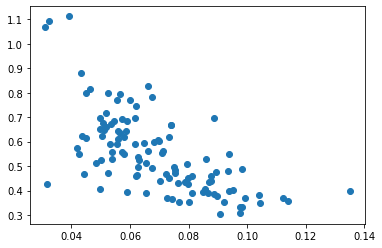

In [659]:
l = momSD
m = pd.DataFrame(momWeight).shift(1)
plt.scatter(l[1:], m[1:])
# Looks as if there is an inverse relationship between SD 
# risk and return for the momentum arm 

In [660]:
momWeight

array([0.79720894, 0.77070126, 0.62164481, 0.68475987, 0.63406633,
       0.61279807, 0.76999585, 0.57580127, 0.82700593, 0.52438086,
       0.69218982, 0.60385179, 0.49588399, 0.46080919, 0.55869389,
       0.60469286, 0.49719055, 0.55076049, 0.59617401, 0.53538996,
       0.55076586, 0.8136741 , 0.74556172, 0.55730634, 0.64191256,
       0.62071267, 0.59764056, 0.50762183, 0.43650534, 0.39895808,
       0.36917916, 0.34830355, 0.33187932, 0.35202854, 0.37668828,
       0.38670903, 0.39068029, 0.4267153 , 0.43440796, 0.43716657,
       0.49318634, 0.51218271, 0.71802092, 0.66711558, 0.46706258,
       0.47889378, 0.3711132 , 0.47581476, 0.38799229, 0.52802261,
       0.40235439, 0.36422603, 0.46529994, 0.55359861, 0.48718444,
       0.35283256, 0.45128437, 0.43460891, 0.43948061, 0.39547207,
       0.58849571, 0.56270749, 0.52355199, 0.54804296, 0.36965919,
       0.30874594, 0.35547509, 0.3043068 , 0.3815444 , 0.33245592,
       0.35487721, 0.43245904, 0.45247138, 0.47213885, 0.66146

In [661]:
sharpe = (monthlyReturn.mean()*12)/(standardDev.mean()*np.sqrt(252))
sharpe

1.1236131165918735

In [662]:
frameWinLos = dfList; frameWinLos['Hedge'] = hedgeWeight
frameWinLos = pd.DataFrame.set_index(frameWinLos, frameWinLos['EndH'])
x = pd.DataFrame(momWeight, index=endH); x = x.rename(columns={0:"Momentum_Weights"})
x['Winners_Returns'] = g_win; x['Losers_Returns'] = g_los 
x['Hedge_Weight'] = frameWinLos['Hedge']
x['VTV_Return'] = g_val; x['SPY_Return'] = g_spy 
x['Winners'] = frameWinLos['Winners']; x['Losers'] = frameWinLos['Losers']
x = pd.DataFrame.sort_index(x, ascending=False)
x['Risk_Metrics'] = 'Risk metrics for Whole Portfolio, Average return: 0.414307%, SD: 0.01645, SemiSD: 0.00956, Max DD: 7.71%, VaR at 5%: 2.314%, CVaR at 5%: 2.695%, Skewness: 0.04543, Excess Kurtosis: -0.543714'
x['Risk_Metrics'].iloc[1:] = ''
# x.to_excel("Momentum_with_VTV_SPY_Hedge.xlsx")
y = pd.DataFrame(monthlyReturn, index=endH); y = y.rename(columns={0:"Strategy_Returns"})
x.head()

# Amend end cell for easier reading by text to columns and then transpose 

/Users/Chris/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Momentum_Weights,Winners_Returns,Losers_Returns,Hedge_Weight,VTV_Return,SPY_Return,Winners,Losers,Risk_Metrics
EndH,,,,,,,,,
2020-06-30,0.256466,0.051682,-0.011953,0.743534,-0.010143,0.017579,"['GDX', 'GDXJ', 'ESPO', 'TAN']","['PXE', 'FRAK', 'JETS', 'PXJ']","Risk metrics for Whole Portfolio, Average retu..."
2020-05-29,0.399119,0.063844,0.000772,0.600881,0.028408,0.046545,"['ESPO', 'TAN', 'GDX', 'PSI']","['JETS', 'FRAK', 'PXE', 'PXJ']",
2020-04-30,0.390291,0.162934,0.202080,0.609709,0.101355,0.119545,"['TAN', 'ESPO', 'GDX', 'GRID']","['FRAK', 'KOL', 'PXE', 'PXJ']",
2020-03-31,0.694766,-0.216320,-0.353717,0.305234,-0.160494,-0.133384,"['TAN', 'PSI', 'ESPO', 'XHB']","['FRAK', 'PXE', 'KOL', 'PXJ']",
2020-02-28,0.698167,0.018888,-0.138950,0.301833,-0.102180,-0.082475,"['TAN', 'PSI', 'GRID', 'ESPO']","['NLR', 'PXE', 'PXJ', 'KOL']",


In [663]:
def modelMonth(i = len(winners)-1): 
    modelRet = np.zeros(len(tickers))
    for j in range(len(tickers)): 
        modelRet[j] = sum(getCSVRet(tickers[j], startH[i], endH[i]))
    return modelRet

In [664]:
rightRet = pd.read_excel('Momentum_with_VTV_SPY_Hedge.xlsx', usecols=[0, 9])
rightRet['EndH'] = pd.to_datetime(rightRet['EndH'], format='%d/%m/%Y')
rightRet

,EndH,Momentum_Return
0,2019-12-31,-0.008668
1,2019-11-29,-0.004672
2,2019-10-31,0.004368
3,2019-09-30,-0.020852
4,2019-08-30,0.043246
...,...,...
90,2012-06-29,-0.001590
91,2012-05-31,0.041818
92,2012-04-30,0.024181
93,2012-03-30,0.019018


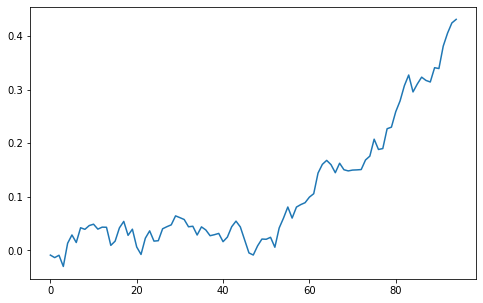

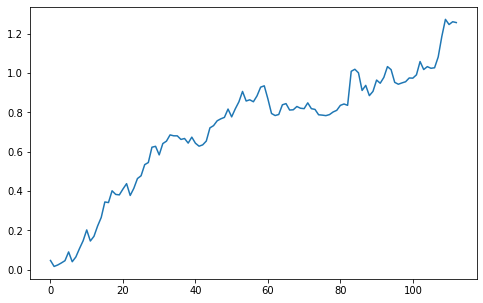

In [665]:
plt.figure(figsize=(8, 5))
plt.plot(rightRet['Momentum_Return'].cumsum()[::-1])
plt.figure(figsize=(8, 5))
plt.plot(monthlyReturn.cumsum())

0.6780615116695716

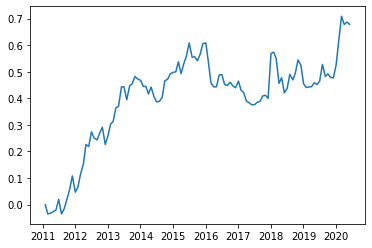

In [666]:
plt.plot(startH, cumRet(monthlyReturn-.00475))
# At 0.475% monthly cost, we breakeven 
cumRet(monthlyReturn-.00475)[-1]

0.8180615116695721

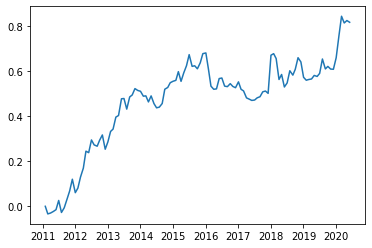

In [667]:
plt.plot(startH, cumRet(monthlyReturn-.0035))
cumRet(monthlyReturn-.0035)[-1]

In [668]:
portRets = pd.DataFrame(pd.concat([startH, pd.DataFrame(monthlyReturn)], axis=1))
portRets.columns = ['StartH', 'FullPort']
portRets.to_csv('FullRet.csv', index=False)

In [669]:
portRets

,StartH,FullPort
0,2011-02-01,0.047311
1,2011-03-01,-0.030329
2,2011-04-01,0.007456
3,2011-05-02,0.010364
4,2011-06-01,0.011531
...,...,...
108,2020-02-03,0.104250
109,2020-03-02,0.087184
110,2020-04-01,-0.026369
111,2020-05-01,0.014275


In [670]:
hedgeWeight

array([ 0.20279106,  0.22929874,  0.37835519,  0.31524013,  0.36593367,
        0.38720193,  0.23000415,  0.42419873,  0.17299407,  0.47561914,
        0.30781018,  0.39614821,  0.50411601,  0.53919081,  0.44130611,
        0.39530714,  0.50280945,  0.44923951,  0.40382599,  0.46461004,
        0.44923414,  0.1863259 ,  0.25443828,  0.44269366,  0.35808744,
        0.37928733,  0.40235944,  0.49237817,  0.56349466,  0.60104192,
        0.63082084,  0.65169645,  0.66812068,  0.64797146,  0.62331172,
        0.61329097,  0.60931971,  0.5732847 ,  0.56559204,  0.56283343,
        0.50681366,  0.48781729,  0.28197908,  0.33288442,  0.53293742,
        0.52110622,  0.6288868 ,  0.52418524,  0.61200771,  0.47197739,
        0.59764561,  0.63577397,  0.53470006,  0.44640139,  0.51281556,
        0.64716744,  0.54871563,  0.56539109,  0.56051939,  0.60452793,
        0.41150429,  0.43729251,  0.47644801,  0.45195704,  0.63034081,
        0.69125406,  0.64452491,  0.6956932 ,  0.6184556 ,  0.66

In [671]:
spRets = pd.DataFrame(startH)
spRets['SPY'] = 0
spRets.columns = ['Date'] + list(spRets.columns)[1:]

for m in range(len(startH)-1):
    r = getCSVRet('SPY', startH[m], endH[m]).sum()
    spRets.loc[m, 'SPY'] = r

spRets['Port'] = monthlyReturn
spRets = spRets.set_index('Date')
spRets

,SPY,Port
Date,,
2011-02-01,0.034148,0.047311
2011-03-01,0.000120,-0.030329
2011-04-01,0.028550,0.007456
2011-05-02,-0.011278,0.010364
2011-06-01,-0.017014,0.011531
...,...,...
2020-02-03,-0.082475,0.104250
2020-03-02,-0.133384,0.087184
2020-04-01,0.119545,-0.026369


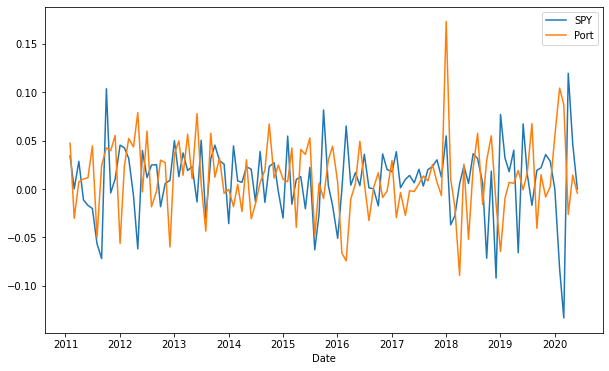

In [672]:
spRets.plot(figsize=(10,6))

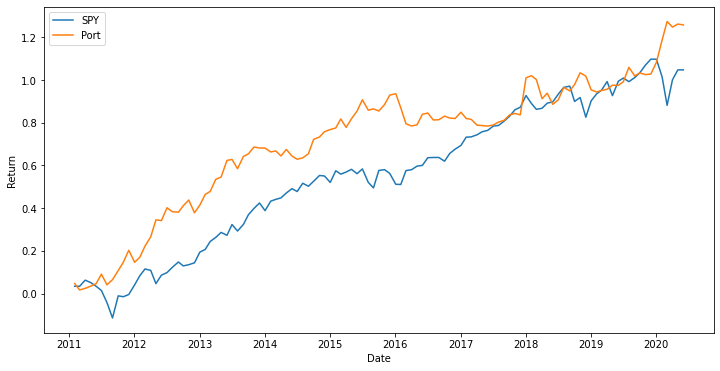

In [673]:
spRets.cumsum().plot(figsize=(12,6)).set_ylabel('Return')
plt.savefig('portSP.png')

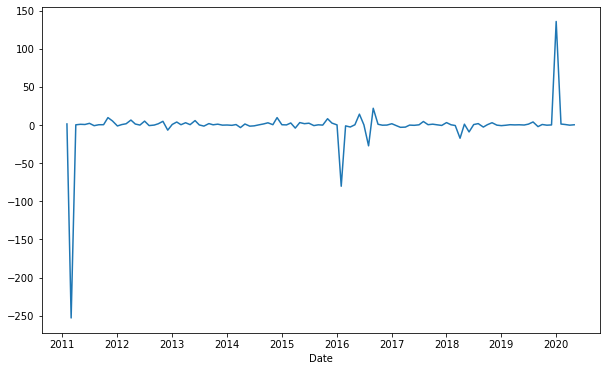

In [674]:
(np.sign(spRets['SPY']) * spRets['Port'] / spRets['SPY']).plot(figsize=(10,6))
plt.savefig('multiple.png')

In [675]:
(np.sign(spRets['SPY']) * spRets['Port'] / spRets['SPY'])[abs(np.sign(spRets['SPY']) * spRets['Port'] / spRets['SPY'])<50].describe()

count    109.000000
mean       0.623204
std        4.774242
min      -27.288791
25%       -0.234401
50%        0.332905
75%        1.621807
max       21.945278
dtype: float64

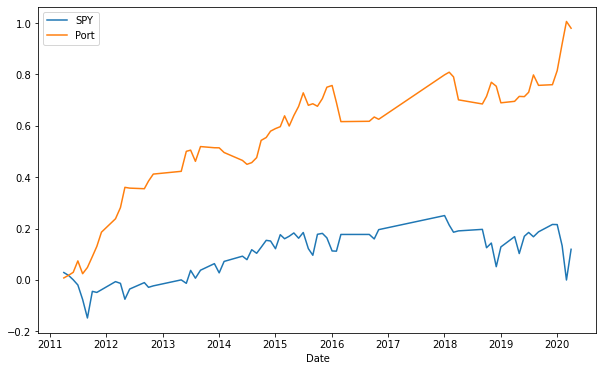

In [676]:
spRets[spRets['SPY'] < 0 | (spRets['SPY'].shift(-1) < 0) | (spRets['SPY'].shift() < 0)].cumsum().plot(figsize=(10,6))

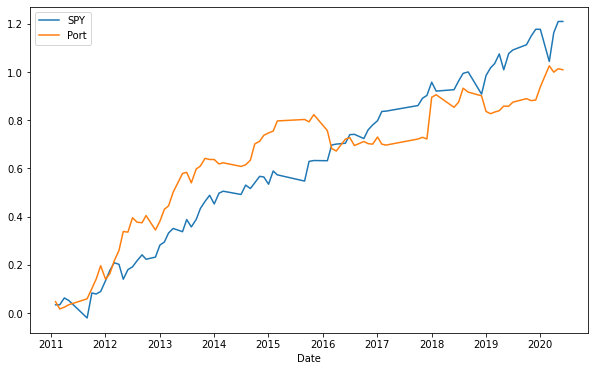

In [677]:
spRets[(spRets['SPY'] > 0.025) | (spRets['SPY'].shift(-1) > 0.025) | (spRets['SPY'].shift() > 0.025)].cumsum().plot(figsize=(10,6))